In [5]:
import numpy as np
import cv2
import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",input_shape=IMAGE_SHAPE+(3,))
])

In [7]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

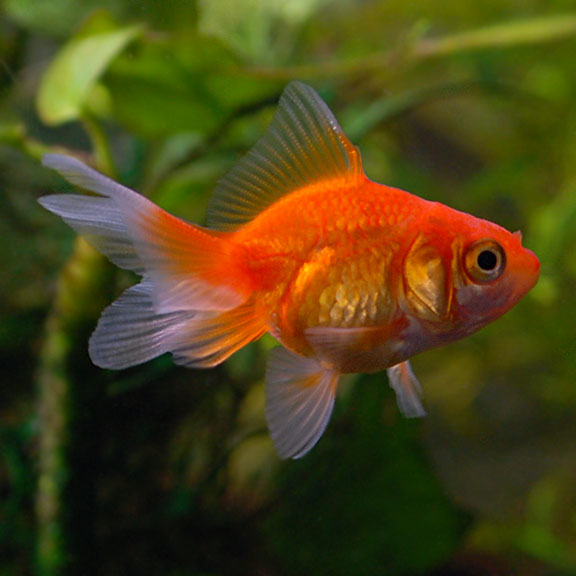

In [8]:
Image.open('goldfish.jpg')

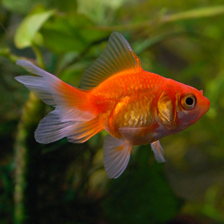

In [9]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [10]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [11]:
gold_fish[np.newaxis,...].shape

(1, 224, 224, 3)

In [12]:
result = classifier.predict(gold_fish[np.newaxis,...])
result.shape

1/1 [==============================] - 3s 3s/step


(1, 1001)

In [13]:
result

array([[ 0.22101447,  2.0474913 ,  9.622561  , ..., -1.4621576 ,
        -0.2814647 , -0.25984675]], dtype=float32)

In [14]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [15]:
image_labels= []
with open('ImageNetLabels.txt', 'r') as f:
    image_labels = f.read().splitlines()

image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [16]:
image_labels[predicted_label_index]

'goldfish'

In [17]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir=".", untar=True)
data_dir

228813984/228813984 [==============================] - 1s 0us/step


'./datasets/flower_photos'

In [18]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [19]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/sunflowers/3731075939_6c92d7fe68_m.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/678714585_addc9aaaef.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/15122871130_6a7d0b4372_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/14741866338_bdc8bfc8d5_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/5979668702_fdaec9e164_n.jpg')]

In [20]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [21]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/5717319579_190e85c7d1_m.jpg'),
 PosixPath('datasets/flower_photos/roses/2535466393_6556afeb2f_m.jpg'),
 PosixPath('datasets/flower_photos/roses/1402130395_0b89d76029.jpg'),
 PosixPath('datasets/flower_photos/roses/4860145119_b1c3cbaa4e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15820572326_be2ea4a55c_n.jpg')]

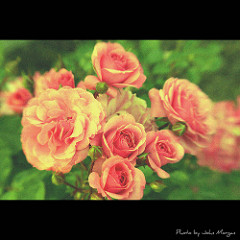

In [22]:
Image.open(str(roses[0]))

In [23]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [24]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [25]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 240, 3)

In [26]:
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [27]:
X, y = [], []
i=0

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        i = i + 1
        if i== 50:
          break
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
print(i)

3079


In [28]:
X = np.array(X)
y = np.array(y)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [30]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

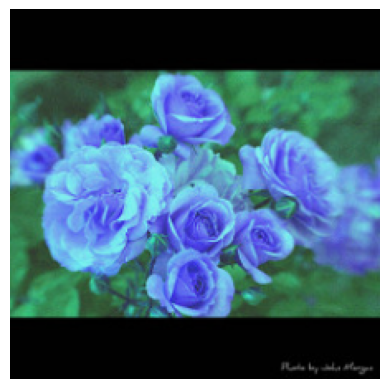

In [31]:
plt.axis('off')
plt.imshow(X[0])

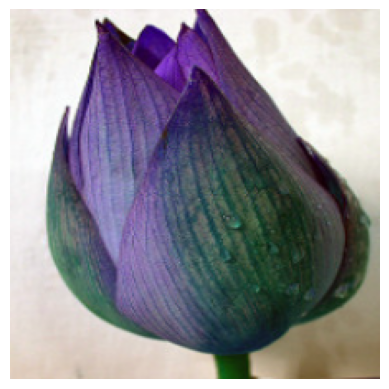

In [32]:
plt.axis('off')
plt.imshow(X[1])

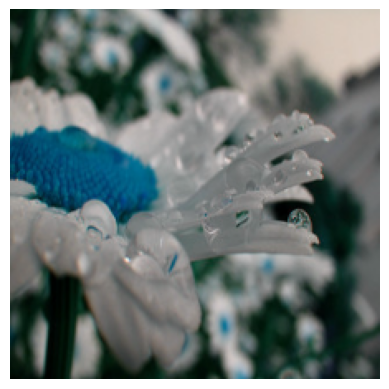

In [33]:
plt.axis('off')
plt.imshow(X[60])

In [34]:
predicted = classifier.predict(np.array([X[0], X[1], X[60]]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 2s 2s/step


array([550, 592, 795])

In [35]:
print(image_labels[795])
print(image_labels[722])
print(image_labels[722])

shower curtain
pillow
pillow


In [36]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)


In [37]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [38]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [39]:
model.fit(X_train_scaled, y_train, epochs=20)

Epoch 1/20
73/73 [==============================] - 10s 49ms/step - loss: 0.7914 - acc: 0.7006
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.3933 - acc: 0.8635
Epoch 3/20
73/73 [==============================] - 3s 43ms/step - loss: 0.2965 - acc: 0.9016
Epoch 4/20
73/73 [==============================] - 3s 40ms/step - loss: 0.2436 - acc: 0.9203
Epoch 5/20
73/73 [==============================] - 3s 40ms/step - loss: 0.2061 - acc: 0.9311
Epoch 6/20
73/73 [==============================] - 3s 40ms/step - loss: 0.1763 - acc: 0.9493
Epoch 7/20
73/73 [==============================] - 3s 42ms/step - loss: 0.1584 - acc: 0.9567
Epoch 8/20
73/73 [==============================] - 3s 41ms/step - loss: 0.1373 - acc: 0.9666
Epoch 9/20
73/73 [==============================] - 3s 40ms/step - loss: 0.1235 - acc: 0.9744
Epoch 10/20
73/73 [==============================] - 3s 41ms/step - loss: 0.1111 - acc: 0.9753
Epoch 11/20
73/73 [==============================] - 3s 42

In [40]:
model.evaluate(X_test_scaled,y_test)

25/25 [==============================] - 2s 64ms/step - loss: 0.3150 - acc: 0.9052


[0.3150031864643097, 0.9051948189735413]